# Hamper Problem - Solving with a Genetic Algorithm

I was posed an interesting problem by a co-worker (who had come across it somewhere online, I'm not sure of the source). I will outline the specifics of the problem below, but in short it is an optimisation problem. I had been reading about the use of Genetic Algorithms at the time (specifically in hyperparameter optimisation and neuro-evolutionary learning) and figured that this problem was a good excuse to code up one myself.

The problem that I'll be solving was proposed as follows:

>A charity purchased some bulk packs, each pack contains 1 or more items. They want to put together as many hampers as they can, with the costs ideally of 5000, and they're all as even as possible, so minimise the sum of the absolute difference of the hamper cost to 5000 across all hampers. Design the hampers with no duplicate items.

Please note that the code in this notebook has been structured to work well in a notebook/blog format, its purpose is to examine/demonstrate how a Genetic Algorithm works and how I applied it to this problem, it does not reflect how I would write the code for a production type usecase. A better structured, standalone version of the code is available in the Github Repo for this project.


## 1. Problem outline

Here is my summary of the problem based on the provided information. There are some points that I would want to discuss/clarify in a real world scenario, but I have made some logical assumptions for these so I can solve the problem . Note that no units for the price were provided so we'll avoid assigning any.

__Goals:__
* Make multiple hampers from the items in the bulk packs
* Minimise the sum of the absolute difference from 5000 for the total cost of the hampers 
* Maximise the number of hampers (I'm assuming the above always takes priority, so this is really a moot point)

__Constraints:__
* Hampers cannot contain duplicate items
* Limited to the number of units specified in the data (i.e. can't exceed this)
* All items must be used (assumed)

__Output:__
* Number of hampers
* Sum of the absolute difference of hamper cost from 5000 across all hampers (we'll refer to this as sum cost difference from here on for brevity)
* The items in each hamper

All libraries that are used in this notebook are imported below.

In [1]:
import json
from random import randint

from tabulate import tabulate
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as rd
import seaborn as sns

sns.set_style("darkgrid")

## 2. Pre-processing the Data
A CSV file has been provided for this problem containing information on the "bulk packs" that have been purchased. I'll use this information to add columns for the total number of units of each item and the cost per unit, which will be needed to solve the problem.

In [2]:
# CSV file containing information on the "bulk packs" of items that need to be used in the hampers
df = pd.read_csv("data/CharityBulkPurchaseList.csv")

# Will need to know the total number of each item that we have available to add to hampers
df["total units"] = df["units per pack"].values * df["quantity of packs"].values
# Will need to know the cost of a single item so we can calc the cost of a hamper down the line
df["price per unit"] = df["price per pack"].values / df["units per pack"].values
# Total cost off all items
df["total item cost"] = df["total units"] * df["price per unit"]

# Display data in table
df.head()

,item,brand,units per pack,price per pack,quantity of packs,total units,price per unit,total item cost
0,Bleach,Blanchite,5,3550,2,10,710.0,7100.0
1,Chickpeas,Southern Style,2,2600,5,10,1300.0,13000.0
2,Coffee,Colombia Select,2,4180,5,10,2090.0,20900.0
3,Flour,Neighbor Mills,10,5200,1,10,520.0,5200.0
4,Lentils,Southern Style,2,2378,5,10,1189.0,11890.0


## 3. Initial predictions
The information available at the moment is enough to quickly determine what an optimised solution might look like in terms of number of hampers and sum cost difference (sum of the absolute difference of the hamper cost to 5000 across all hampers). It's worth doing this before diving in to solve the problem as it will help to narrow the search space and allow us to compare possible solutions to the ideal solution. 

### Determining the ideal number of hampers

The best possible outcome is to have all hampers be worth 5000. We can find the number of hampers that will be closest to this by dividing the total cost of all items by 5000 and rounding to the nearest whole number.

Note: This is the same as setting $\Delta_{ideal\:cost}$ to zero in the equation below and solving for $n_{hampers}$.

In [3]:
# Find the total cost of all items to be used in hampers
total_cost = df["total item cost"].sum()

# Determine how many hampers valued exactly 5000 can be made
n = total_cost / 5000

# Round to nearest whole number since we can't have a fraction of a hamper
n_int = round(n)

print(f"Ideal number of hampers = {n_int}")

Ideal number of hampers = 25


### Calculating the lowest possible difference
We know that the ideal total cost of the hampers will be $5000 \times n_{hampers}$, where $n_{hampers}$ is the number of hampers. If we subtract the total cost of the items from this number we should arrive at the best possible sum cost difference for that number of hampers.

$$ \Delta_{ideal\:cost} = | 5000 \times n_{hampers} - \sum_{i=0}^{n_i}{price_i} | $$

Where $n_{hampers}$ is the number of hampers and $price_i$ is the price of a single item

We are assuming that the items are distributed evenly.

In [4]:
def calc_lowest_difference(
    n_hampers: int,
    total_cost: float
) -> float:
    return np.abs(5000 * n_hampers - total_cost)

Using the equation above and the ideal number of hampers calculated in the previous section (25) we can calculated the lowest possible "sum of the absolute difference of the hamper cost to 5000 across all hampers"

In [5]:
# Number of hampers that we will make from the items
n_hampers = 25

lowest_diff = calc_lowest_difference(n_hampers, total_cost)

print(f"Best possible sum cost difference = {lowest_diff}")

Best possible sum cost difference = 1709.0


### Sum cost difference vs Number of Hampers
Below is a plot of the best possible "sum of the absolute difference of the hamper cost to 5000 across all hampers" for a range of hamper numbers. Based on this 25 the best number of hampers by a significant margin.

Text(0, 0.5, 'Sum cost difference')

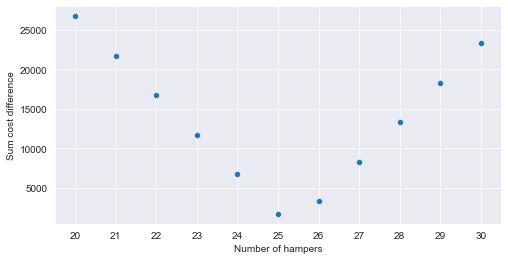

In [12]:
%matplotlib inline
sns.set_style("darkgrid")

# Want to plot sum cost difference for a range of hamper numbers
num_hamper_range = np.array(range(20, 31)).astype(int)

# Best possible sum cost difference for each number of hampers
difference = calc_lowest_difference(num_hamper_range, total_cost)

# Plot sum cost difference of hampers against number of hampers
_, ax = plt.subplots(figsize=[8,4])
sns.scatterplot(x=num_hamper_range, y=difference, ax=ax)

# Only show ints on x axis
ax.set_xticks(np.arange(min(num_hamper_range), max(num_hamper_range)+1, 1.0))
# Labels
ax.set_xlabel("Number of hampers")
ax.set_ylabel("Sum cost difference")

## 4. Building the Genetic Algorithm

A Genetic Algorithm is a type of evolutionary algorithm that was inspired by natural selection. This algorithm will look to evolve an initial set of possible solutions (in this case randomised) to an optimised solution. It does this by "breeding" and "mutating" the best solutions (refered to as chromosomes) over multiple generations. 

The Genetic Algorithm used for this problem will take the following steps (This is visualised in the diagram below):
* __Step 1 - Initialise population__: This is done at the start of the process and provides an initial population of solutions for the algorithm to work with. In this case it will be a set of psuedo-random solutions that fit the constraits of the problem (e.g. no duplicate items in a hamper).
* __Step 2 - Fitness calculation__: The fitness calculation provides a metric to score which chromosomes are performing the best. In this case it will be the sum of the absolute difference from 5000 across all hampers.
* __Step 3 - Check if it should terminate__: Determine if the target fitness has been met or some other limit reached (e.g. total number of generations or no improvement in n generations).
* __Step 4 - Selection__: Select the fittest solutions to make the next generation
* __Step 5 - Crossover__: Combine fittest "parent" solutions to create new solutions (parents will also be in the next generation)
* __Step 6 - Mutation__: Randomly change parts of the solutions for some of the new population.
* __Repeat from Step 2__ until a termination criterum is met

<img src="./data/GAProcessDiagram.png" width=300/>

Note: Genetic Algorithms will find __an__ optimised solution not always the most optimal solution. They can potentially give different answers each time they are run. There are other approaches better suited to finding the most optimal solution (and more efficient approaches), but I wanted to play around with this kind of algorithm.

### The Chromosome

In [7]:
def chromosome_to_hampers(chromosome: list, num_hampers: int) -> list:
    # Item in hamper shouldn't be greater than the number of hampers
    if any(hamper > num_hampers - 1 for pack in chromosome for hamper in pack):
        msg = f"Hamper in chromosome is greater than num_hampers {num_hampers}"
        raise Exception(msg)

    # Empty hampers to add items into
    hampers = [[] for _ in range(num_hampers)]

    # Iterate through chromosome to put items into their hampers
    for i, pack in enumerate(chromosome):
        for assigned_hamper in pack:
            hampers[assigned_hamper].append(i)

    return hampers


hampers = chromosome_to_hampers([[0,1,2],[3,4,1],[0,4,3]], 5)
print(hampers)

[[0, 1, 1, 0]]

[[0, 2], [0, 1], [0], [1, 2], [1, 2]]


###  Initialisation

The genetic algorithm will need an inital set of solutions to optimised. These will be created by randomly assigning items to hampers. It will be important to do this in a way that ensure the hampers that are created are valid (i.e. no duplicate items) otherwise there is the potential for many or all of the random solutions to be invalid which can significantly slow down the optimisation.

This is done by keeping track of the hampers that an item can be added to (i.e. hampers that don't already contain that item).

In [8]:
def make_random_solution(num_hampers: int, item_lookup: dict) -> list:
    solutions = []
    for item in item_lookup:
        num_units = item_lookup[item]["total units"]
        pack = randomly_distribute_pack(num_units, num_hampers)
        solutions.append(pack)

    return solutions


def randomly_distribute_pack(num_units: int, num_hampers: int) -> list:
    # Will track which hampers an item can be assigned to.
    hamper_options = list(range(1, num_hampers + 1))

    # Go through each unit of an item and distribute it to a hamper
    item_assignments = []
    for i in range(num_units):
        # Randomly select a hamper from the available hampers to assign the item to
        available_hampers = len(hamper_options) - 1
        hamper_idx = randint(0, available_hampers)

        # Remove the hamper as it is no longer available
        hamper = hamper_options.pop(hamper_idx)

        item_assignments.append(hamper)

    return item_assignments

### Fitness

Once we have an initial population to work with, we need a way of assessing the fitness of a given solution. 
We then need to assign a score based on the sum absolute difference of the hampers from the target value of 5000. To do this will we calculate the ideal sum value of the hampers $(5000 \times n_{hampers})$. Our fitness score will be based on how far from this we are. So we will be aiming to maximise the equation below.

$$ 5000 \times n_{hampers} - \sum_{i=1}^{n_{hampers}} | 5000 - \sum_{i=1}^{n_{i}} price_i | $$

Solutions that are invalid are given a fitness of 0.

In [9]:
def calc_fitness(
    chromosome: list,
    item_lookup: dict,
    num_hampers: int,
    target_hamper_value: float
) -> float:
    # Make hampers from chromosome so we can calculate their value
    hampers = chromosome_to_hampers(chromosome, num_hampers)

    # Hamper value for all hampers in solution so we can find the sum of the absolute
    hamper_values = [calc_hamper_value(hamper, item_lookup) for hamper in hampers]

    # difference from 5000 across all hampers
    diffs = [abs(value - target_hamper_value) for value in hamper_values]

    return sum(diffs)

### Selection

Now we have a function for determining fitness of a solution we now need to write a function that selects solutions to use a parents for the next generation.

In [10]:
def selection(fitness: list, num_parents: int, population: list) -> list:
    """Select the fittest solutions to use as parents for the next generation."""
    # Predefine array of indivduals that will be parents for the next generation
    parents = np.empty((num_parents, population.shape[1]))
    for i in range(num_parents):
        # Finding the fittest solution
        max_fitness_idx = np.where(fitness == np.max(fitness))
        parents[i,:] = population[max_fitness_idx[0][0], :]
        # Ensuring this solution is not selected next time
        fitness[max_fitness_idx[0][0]] = -999999
    return parents

### Crossover

### Mutation

### Termination